# **Efficient Frontier Optimization**

### **Concept and Background**

The **Efficient Frontier** is a fundamental concept in *Modern Portfolio Theory (MPT)*, introduced by **Harry Markowitz (1952)**.
It represents the set of all optimal portfolios that offer the **highest expected return for a given level of risk**, or equivalently, the **lowest possible risk for a given expected return**.

Each point on the Efficient Frontier corresponds to a particular allocation of assets (portfolio weights).
Portfolios below this curve are **sub-optimal** — they either take too much risk for their return or deliver too little return for their level of risk.

Mathematically, for a portfolio with $n$ assets:

$$
E[R_p] = \sum_{i=1}^{n} w_i , \mu_i
$$

$$
\sigma_p^2 = w^T \Sigma w
$$

where:

* $w_i$ = portfolio weight of asset *i*
* $\mu_i$ = expected return of asset *i*
* $\Sigma$ = covariance matrix of asset returns
* $E[R_p]$ = expected return of the portfolio
* $\sigma_p$ = portfolio standard deviation (volatility)

The optimization seeks to **maximize the Sharpe Ratio**:

$$
\text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}
$$

where $R_f$ is the risk-free rate.
The Sharpe Ratio measures the **excess return per unit of risk**, and the portfolio with the **maximum Sharpe Ratio** is called the *tangency portfolio*.

### **Implementation in This Code**

In this project, the function **`eff_front_simulation()`** performs a **rolling Efficient Frontier optimization** using real price data and predicted returns to dynamically adjust portfolio weights over a short-term trading horizon.

#### 🔹 Purpose

To continuously rebalance portfolio allocations across multiple assets (NIFTY indices or major Indian stocks) to achieve **optimal risk-adjusted performance** during the investment window.

#### 🔹 Steps Inside the Code

1. **Data Loading**

   * Reads predicted price CSVs for all tickers from the `Pred_Data` folder.
   * Computes **actual returns** from `ActualPrice` columns.
   * Filters data between `apply_date` and `withdraw_date`.

2. **Rolling Optimization**

   * For each timestamp (hour) in the simulation window:

     * Takes the past *k* days of returns as a **lookback window**.
     * Computes:

       * Mean returns ($\mu_i$)
       * Covariance matrix ($\Sigma$)
     * Solves the constrained optimization problem:

       $$
       \max_w \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}}
       $$

       subject to:

       $$
       \sum_{i=1}^{n} w_i = 1, \quad 0 \le w_i \le 1
       $$

       This gives the **maximum Sharpe ratio** portfolio at each time point.

3. **Portfolio Simulation**

   * Applies the optimized weights to actual next-period returns to simulate realized portfolio performance.
   * Tracks:

     * Weights (`weights_history`)
     * Instantaneous returns (`port_returns`)
     * Risk (volatility) and Sharpe ratio per hour.

4. **Performance Summary**

   * Aggregates the total simulated portfolio return across all intervals:
     $$
     R_{\text{total}} = \prod_t (1 + R_t) - 1
     $$
   * Computes average volatility and optionally **Value at Risk (VaR)** to quantify potential losses at a chosen confidence level.

### **Interpretation**

* The algorithm creates a **dynamic Efficient Frontier**, updating portfolio weights every hour using recent (last *k* days) data.
* It reflects a **realistic intraday trading scenario**, where the market structure changes rapidly.
* The output includes:

  * `summary` — overall return, risk, and VaR
  * `weights_history` — allocation evolution over time

### **Key Takeaways**

| Concept                          | Meaning                                                |
| -------------------------------- | ------------------------------------------------------ |
| **Efficient Frontier**           | Set of portfolios optimizing return for given risk     |
| **Sharpe Ratio Optimization**    | Maximizes risk-adjusted return                         |
| **Covariance Matrix ($\Sigma$)** | Captures inter-asset risk relationships                |
| **Rolling Window ($k$ days)**    | Keeps model adaptive to recent volatility              |
| **Output**                       | Time-varying weights and portfolio performance metrics |


### **Significance**

This implementation bridges **classical Markowitz portfolio optimization** with **modern short-term trading** by:

* Using **predicted prices** as expected returns ($\mu_i$)
* Recomputing **variance–covariance** structure in rolling windows
* Dynamically producing **hourly optimal weights**
* Making the model suitable for **intradaily portfolio adjustment**

Thus, the function transforms the traditional static Efficient Frontier into a **rolling, data-driven, real-time optimizer**, ideal for **short-term investment strategies and algorithmic trading systems**.


In [14]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

predicted_data_folder = r"Pred_Data"

ticker_to_basename = {
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

In [15]:
# ticker_to_basename = {
#     # "^NSEI": "NIFTY_50",
#     "^NSEBANK": "NIFTY_BANK",
#     "^CNXIT": "NIFTY_IT",
#     "^CNXPHARMA": "NIFTY_PHARMA",
#     "^CNXFMCG": "NIFTY_FMCG",
#     "^CNXAUTO": "NIFTY_AUTO",
#     "^CNXMETAL": "NIFTY_METAL",
#     "^CNXREALTY": "NIFTY_REALTY",
#     "^CNXENERGY": "NIFTY_ENERGY",
#     "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    
#     "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
#     "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
#     "HDFCBANK.NS": "HDFC_BANK_LTD",
#     "ICICIBANK.NS": "ICICI_BANK_LTD.",
#     "INFY.NS": "INFOSYS_LIMITED",
#     "SBIN.NS": "STATE_BANK_OF_INDIA",
#     "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
#     "ITC.NS": "ITC_LTD",
#     "LT.NS": "LARSEN_&_TOUBRO_LTD.",
#     "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
# }

In [16]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary

In [17]:
# Portfolio optimization
def optimize_intraday_portfolio(start_date, end_date, simulate_investment, rf=0.0):
    actual_returns = {}
    expected_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df = df.set_index("Datetime")

        # Filter between given dates
        df = df.loc[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]

        if df.empty:
            continue

        actual_returns[basename] = df["Actual_Return"].dropna()

        # Expected return via your simulation
        try:
            sim = simulate_investment(df, amt=100000, start_date=start_date, end_date=end_date, plot=False)
            expected_returns[basename] = sim["Return (%)"] / 100.0
        except Exception:
            continue

    if not actual_returns:
        raise ValueError("No valid data found for given date range")

    # Convert to DataFrames
    actual_df = pd.concat(actual_returns, axis=1).dropna()
    cov_matrix = actual_df.cov()
    expected_ret = pd.Series(expected_returns)

    # --- Optimization ---
    n = len(expected_ret)
    mean_returns = expected_ret.values

    # Portfolio performance function
    def portfolio_performance(weights):
        ret = np.dot(weights, mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
        sharpe = (ret - rf) / vol if vol > 0 else 0
        return ret, vol, sharpe

    # Objective: negative Sharpe ratio (maximize Sharpe)
    def neg_sharpe(weights):
        _, _, sharpe = portfolio_performance(weights)
        return -sharpe

    # Constraints: sum(weights)=1, bounds=[0,1]
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    init_guess = np.ones(n) / n

    opt_result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)

    best_weights = opt_result.x
    ret, vol, sharpe = portfolio_performance(best_weights)

    result = pd.DataFrame({
        "Asset": expected_ret.index,
        "Weight": best_weights,
        "Expected_Return": expected_ret.values
    }).sort_values(by="Weight", ascending=False)

    # --- Format and Display Results ---
    result["Weight"] = result["Weight"].map(lambda x: f"{x:.8f}")
    result["Expected_Return"] = result["Expected_Return"].map(lambda x: f"{x:.4f}")

    print("\n=== Optimal Intraday Portfolio ===")
    print(result.to_string(index=False))

    print(f"\nPortfolio Expected Return: {ret:.4f}")
    print(f"Portfolio Volatility: {vol:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    return result, cov_matrix, {"Return": ret, "Volatility": vol, "Sharpe": sharpe}


In [18]:
opt_result, cov_matrix, stats = optimize_intraday_portfolio(
    start_date="2025-10-01",
    end_date="2025-11-06",
    simulate_investment=simulate_investment,
    rf=0.05 / 252  # risk-free rate (daily)
)


=== Optimal Intraday Portfolio ===
                   Asset     Weight Expected_Return
              NIFTY_FMCG 0.50216498          0.0781
     STATE_BANK_OF_INDIA 0.15935522          0.0819
   BHARTI_AIRTEL_LIMITED 0.14476686          0.0918
             NIFTY_METAL 0.10017948          0.0513
         INFOSYS_LIMITED 0.07652302          0.0756
SUN_PHARMACEUTICAL_IND_L 0.01701044          0.0404
    LARSEN_&_TOUBRO_LTD. 0.00000000         -0.0021
              NIFTY_AUTO 0.00000000          0.0082
 HINDUSTAN_UNILEVER_LTD. 0.00000000          0.0363
                NIFTY_50 0.00000000          0.0376
TATA_CONSULTANCY_SERV_LT 0.00000000          0.0273
            NIFTY_REALTY 0.00000000          0.0452
                 ITC_LTD 0.00000000          0.0639
         ICICI_BANK_LTD. 0.00000000         -0.0024
            NIFTY_PHARMA 0.00000000          0.0184
              NIFTY_BANK 0.00000000          0.0412
       NIFTY_FIN_SERVICE 0.00000000          0.0459
            NIFTY_ENERGY 0.0

In [19]:
# def eff_front_simulation(predicted_data_folder, ticker_to_basename, simulate_investment,
#                          apply_date, withdraw_date, k=3, rf=0.0):
#     """
#     Rolling Efficient Frontier Simulation.
#     Each hour between apply_date and withdraw_date, optimize portfolio weights 
#     using past k days of actual data for covariance and mean estimation.

#     Returns:
#       summary: dict with total return, avg risk, start & end date
#       weights_history: DataFrame of weights per timestamp (row=time, col=asset)
#     """

#     # --------------------------
#     # 1. Load data
#     # --------------------------
#     all_returns = {}

#     for ticker, basename in ticker_to_basename.items():
#         file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
#         if not os.path.exists(file_path):
#             continue

#         df = pd.read_csv(file_path, parse_dates=["Datetime"])
#         df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

#         if len(df) <= 300:
#             continue

#         df = df.iloc[300:].copy()
#         df["Actual_Return"] = df["ActualPrice"].pct_change()
#         df = df.set_index("Datetime")

#         # Filter between apply_date - k days and withdraw_date
#         start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
#         mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
#         df = df.loc[mask]
#         if df.empty:
#             continue

#         all_returns[basename] = df["Actual_Return"].dropna()

#     if not all_returns:
#         raise ValueError("No valid assets with data between given dates")

#     # Align all assets on same timestamps
#     actual_df = pd.concat(all_returns, axis=1).dropna()
#     time_points = actual_df.loc[
#         (actual_df.index >= pd.to_datetime(apply_date)) & 
#         (actual_df.index <= pd.to_datetime(withdraw_date))
#     ].index.unique()

#     # --------------------------
#     # 2. Rolling optimization
#     # --------------------------
#     weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
#     results = []
#     port_returns = []

#     for current_time in time_points:
#         # Define rolling window (past k days)
#         window_start = current_time - pd.Timedelta(days=k)
#         window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

#         if len(window_df) < 10:
#             continue

#         cov_matrix = window_df.cov()
#         mean_returns = window_df.mean().values
#         n = len(mean_returns)

#         # Portfolio performance
#         def performance(w):
#             ret = np.dot(w, mean_returns)
#             vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
#             sharpe = (ret - rf) / vol if vol > 0 else 0
#             return ret, vol, sharpe

#         def neg_sharpe(w):
#             _, _, sharpe = performance(w)
#             return -sharpe

#         cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
#         bounds = tuple((0, 1) for _ in range(n))
#         w0 = np.ones(n) / n

#         opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
#         opt_w = opt.x

#         weights_history.loc[current_time, :] = opt_w

#         # Compute portfolio stats
#         ret, vol, sharpe = performance(opt_w)
#         results.append((current_time, ret, vol, sharpe))

#         # Apply the weights to next return (forward-looking return simulation)
#         if current_time in actual_df.index:
#             port_returns.append(np.dot(opt_w, actual_df.loc[current_time].values))

#     # --------------------------
#     # 3. Aggregate results
#     # --------------------------
#     weights_history = weights_history.dropna(how="all")
#     port_returns = np.array(port_returns)

#     total_return = np.prod(1 + port_returns) - 1
#     avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])


#     summary = {
#         "Invest_Day": str(apply_date),
#         "Withdraw_Day": str(withdraw_date),
#         "Lookback_Days": k,
#         "Total_Return": float(total_return),
#         "Average_Risk": float(avg_risk)
#     }

#     # 4. Compute Value at Risk (VaR)
#     # --------------------------
#     confidence_level = 0.95
#     z_score = 1.65 

#     # Use realized portfolio return distribution
#     mu_p = np.mean(port_returns)
#     sigma_p = np.std(port_returns)

#     # Parametric (Normal) VaR
#     var_parametric = -(mu_p - z_score * sigma_p)

#     # Historical (non-parametric) VaR
#     var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)

#     summary["Parametric_VaR"] = float(var_parametric)
#     summary["Historical_VaR"] = float(var_historical)
#     summary["Confidence_Level"] = confidence_level

#     print("\nRolling Efficient Frontier Simulation")
#     print(f"Parametric VaR (95%): {var_parametric:.4%}")
#     print(f"Investment Period: {apply_date} → {withdraw_date}")
#     print(f"Lookback Window: {k} days")
#     print(f"Total Return: {total_return:.4%}")
#     print(f"Average Risk (Volatility): {avg_risk:.6f}")
#     print(f"Total Optimization Points: {len(results)}")

#     return summary, weights_history


In [20]:
# summary, weights_df = eff_front_simulation(
#     predicted_data_folder=predicted_data_folder,
#     ticker_to_basename=ticker_to_basename,
#     simulate_investment=simulate_investment,
#     apply_date="2025-10-01",
#     withdraw_date="2025-10-20",
#     k=100,
#     rf=0.05 / 252
# )


In [21]:
def eff_front_simulation(predicted_data_folder, ticker_to_basename, simulate_investment,
                         apply_date, withdraw_date, k=3, rf=0.0):
    """
    Rolling Efficient Frontier Simulation.
    Each hour between apply_date and withdraw_date, optimize portfolio weights 
    using past k days of actual data for covariance and mean estimation.

    Returns:
      summary: dict with total return, avg risk, start & end date
      weights_history: DataFrame of weights per timestamp (row=time, col=asset)
      return_df: DataFrame with Datetime, Predicted_Return, and Actual_Return
    """

    # --------------------------
    # 1. Load data
    # --------------------------
    all_returns = {}
    all_predicted_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df["Predicted_Return"] = df["PredictedPrice"].pct_change()
        df = df.set_index("Datetime")

        # Filter between apply_date - k days and withdraw_date
        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()
        all_predicted_returns[basename] = df["Predicted_Return"].dropna()

    if not all_returns:
        raise ValueError("No valid assets with data between given dates")

    # Align all assets on same timestamps
    actual_df = pd.concat(all_returns, axis=1).dropna()
    predicted_df = pd.concat(all_predicted_returns, axis=1).reindex(actual_df.index).fillna(0)
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    # --------------------------
    # 2. Rolling optimization
    # --------------------------
    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    results = []
    port_returns = []

    for current_time in time_points:
        # Define rolling window (past k days)
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

        if len(window_df) < 10:
            continue

        cov_matrix = window_df.cov()
        mean_returns = window_df.mean().values
        n = len(mean_returns)

        # Portfolio performance
        def performance(w):
            ret = np.dot(w, mean_returns)
            vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
            sharpe = (ret - rf) / vol if vol > 0 else 0
            return ret, vol, sharpe

        def neg_sharpe(w):
            _, _, sharpe = performance(w)
            return -sharpe

        cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
        bounds = tuple((0, 1) for _ in range(n))
        w0 = np.ones(n) / n

        opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
        opt_w = opt.x

        weights_history.loc[current_time, :] = opt_w

        # Compute portfolio stats
        ret, vol, sharpe = performance(opt_w)
        results.append((current_time, ret, vol, sharpe))

        # Apply the weights to next return (forward-looking return simulation)
        if current_time in actual_df.index:
            port_returns.append(np.dot(opt_w, actual_df.loc[current_time].values))

    # --------------------------
    # 3. Aggregate results
    # --------------------------
    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk)
    }

    # --------------------------
    # 4. Compute Value at Risk (VaR)
    # --------------------------
    confidence_level = 0.95
    z_score = 1.65  # 95%

    mu_p = np.mean(port_returns)
    sigma_p = np.std(port_returns)

    var_parametric = -(mu_p - z_score * sigma_p)
    var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)

    summary["Parametric_VaR"] = float(var_parametric)
    summary["Historical_VaR"] = float(var_historical)
    summary["Confidence_Level"] = confidence_level

    # --------------------------
    # 5. Return DataFrame of Actual & Predicted Returns
    # --------------------------
    return_df = pd.DataFrame({
        "Datetime": actual_df.index,
        "Actual_Return": actual_df.mean(axis=1),
        "Predicted_Return": predicted_df.mean(axis=1)
    }).reset_index(drop=True)

    # --------------------------
    # 6. Console Output
    # --------------------------
    print("\nRolling Efficient Frontier Simulation")
    print(f"Parametric VaR (95%): {var_parametric:.4%}")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    print(f"Total Optimization Points: {len(results)}")

    # Return all three outputs
    return summary, weights_history, return_df


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def eff_front_simulation(predicted_data_folder, ticker_to_basename, simulate_investment,
                         apply_date, withdraw_date, k=3, rf=0.0):
    """
    Rolling Efficient Frontier Simulation.
    Each hour between apply_date and withdraw_date, optimize portfolio weights 
    using past k days of actual data for covariance and mean estimation.

    Returns:
      summary: dict with total return, avg risk, start & end date, VaR
      weights_history: DataFrame of weights per timestamp (row=time, col=asset)
      return_df: DataFrame with Datetime, Actual_Return, and Predicted_Return
      portfolio_df: DataFrame with Datetime and Portfolio_Value (₹100 base)
    """

    # --------------------------
    # 1. Load data
    # --------------------------
    all_returns = {}
    all_predicted_returns = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df["Predicted_Return"] = df["PredictedPrice"].pct_change()
        df = df.set_index("Datetime")

        # Filter between apply_date - k days and withdraw_date
        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()
        all_predicted_returns[basename] = df["Predicted_Return"].dropna()

    if not all_returns:
        raise ValueError("No valid assets with data between given dates")

    # Align all assets on same timestamps
    actual_df = pd.concat(all_returns, axis=1).dropna()
    predicted_df = pd.concat(all_predicted_returns, axis=1).reindex(actual_df.index).fillna(0)
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    # --------------------------
    # 2. Rolling optimization
    # --------------------------
    weights_history = pd.DataFrame(index=time_points, columns=list(all_returns.keys()), dtype=float)
    results = []
    port_returns = []

    for current_time in time_points:
        # Define rolling window (past k days)
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

        if len(window_df) < 10:
            continue

        cov_matrix = window_df.cov()
        mean_returns = window_df.mean().values
        n = len(mean_returns)

        # Portfolio performance
        def performance(w):
            ret = np.dot(w, mean_returns)
            vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
            sharpe = (ret - rf) / vol if vol > 0 else 0
            return ret, vol, sharpe

        def neg_sharpe(w):
            _, _, sharpe = performance(w)
            return -sharpe

        cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
        bounds = tuple((0, 1) for _ in range(n))
        w0 = np.ones(n) / n

        opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
        opt_w = opt.x

        weights_history.loc[current_time, :] = opt_w

        # Compute portfolio stats
        ret, vol, sharpe = performance(opt_w)
        results.append((current_time, ret, vol, sharpe))

        # Apply weights to next return (realized portfolio)
        if current_time in actual_df.index:
            port_returns.append(np.dot(opt_w, actual_df.loc[current_time].values))

    # --------------------------
    # 3. Aggregate results
    # --------------------------
    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])

    # --------------------------
    # 4. Compute Value at Risk (VaR)
    # --------------------------
    confidence_level = 0.95
    z_score = 1.65  # 95%

    mu_p = np.mean(port_returns)
    sigma_p = np.std(port_returns)

    var_parametric = -(mu_p - z_score * sigma_p)
    var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk),
        "Parametric_VaR": float(var_parametric),
        "Historical_VaR": float(var_historical),
        "Confidence_Level": confidence_level
    }

    # --------------------------
    # 5. Create DataFrames for Output
    # --------------------------
    valid_times = [r[0] for r in results]  # timestamps where optimization succeeded
    portfolio_value = 100 * (1 + pd.Series(port_returns, index=valid_times)).cumprod()


    # Portfolio growth dataframe
    portfolio_df = pd.DataFrame({
        "Datetime": portfolio_value.index,
        "Portfolio_Value": portfolio_value.values
    }).reset_index(drop=True)

    # --------------------------
    # 6. Console Output
    # --------------------------
    print("\n=== Rolling Efficient Frontier Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    print(f"Parametric VaR (95%): {var_parametric:.4%}")
    print(f"Historical VaR (95%): {var_historical:.4%}")
    print(f"Total Optimization Points: {len(results)}")

    # --------------------------
    # 7. Plot Realized Portfolio Growth
    # --------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_df["Datetime"], portfolio_df["Portfolio_Value"], color='darkgreen', lw=2)
    plt.title("Efficient Frontier Portfolio — ₹100 Investment Growth", fontsize=13)
    plt.xlabel("Datetime")
    plt.ylabel("Portfolio Value (₹)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Annotate final value
    final_val = portfolio_df["Portfolio_Value"].iloc[-1]
    plt.text(portfolio_df["Datetime"].iloc[-1], final_val,
             f" ₹{final_val:.2f}", fontsize=10, color='black', ha='left', va='center')
    plt.show()

    # --------------------------
    # 8. Return
    # --------------------------
    return summary, weights_history, portfolio_df



=== Rolling Efficient Frontier Simulation ===
Investment Period: 2025-10-06 → 2025-11-06
Lookback Window: 10 days
Total Return: 15.0529%
Average Risk (Volatility): 0.002709
Parametric VaR (95%): 0.3664%
Historical VaR (95%): 0.2710%
Total Optimization Points: 142


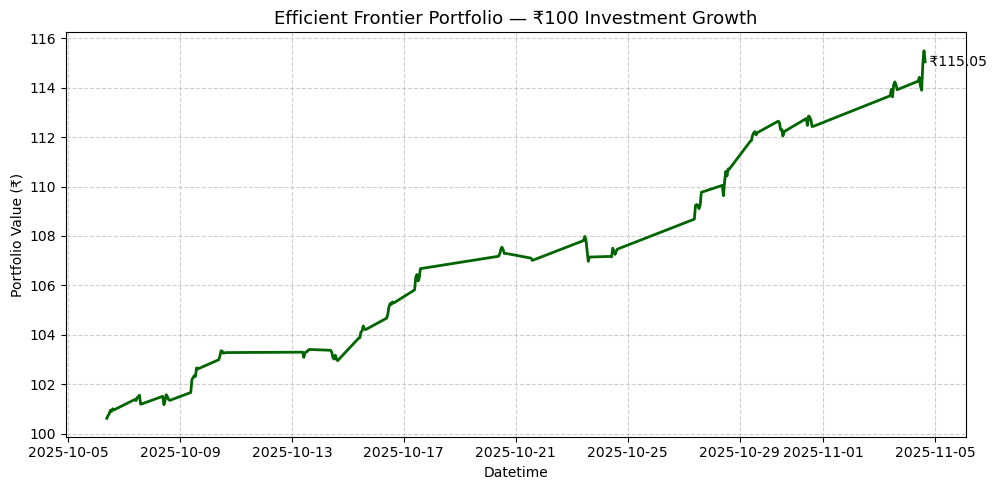

In [28]:
summary, weights_df, result_df = eff_front_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    apply_date="2025-10-06",
    k = 10,
    withdraw_date="2025-11-06",
    rf=0.05 / 252
)


In [24]:
result_df.to_csv("result.csv")

In [25]:
weights_df.to_csv("wt_st_63.csv")
weights_df

,NIFTY_50,NIFTY_BANK,NIFTY_IT,NIFTY_PHARMA,NIFTY_FMCG,NIFTY_AUTO,NIFTY_METAL,NIFTY_REALTY,NIFTY_ENERGY,NIFTY_FIN_SERVICE,RELIANCE_INDUSTRIES_LTD,TATA_CONSULTANCY_SERV_LT,SUN_PHARMACEUTICAL_IND_L,ICICI_BANK_LTD.,INFOSYS_LIMITED,STATE_BANK_OF_INDIA,BHARTI_AIRTEL_LIMITED,ITC_LTD,LARSEN_&_TOUBRO_LTD.,HINDUSTAN_UNILEVER_LTD.
Datetime,,,,,,,,,,,,,,,,,,,,
2025-10-06 09:15:00,0.000000e+00,0.000000e+00,2.024502e-16,7.480364e-17,4.222677e-19,0.000000e+00,6.885945e-01,1.564451e-16,0.000000e+00,0.000000e+00,1.563953e-16,1.941796e-16,0.000000e+00,1.586943e-17,3.331043e-16,0.292376,1.641522e-16,1.548940e-17,0.019029,9.280898e-17
2025-10-06 10:15:00,1.350958e-16,2.760222e-16,0.000000e+00,0.000000e+00,0.000000e+00,5.401434e-16,6.365063e-01,0.000000e+00,5.758779e-16,4.228747e-16,0.000000e+00,0.000000e+00,8.824757e-16,0.000000e+00,0.000000e+00,0.295069,0.000000e+00,0.000000e+00,0.068425,0.000000e+00
2025-10-06 11:15:00,8.111375e-17,0.000000e+00,5.813047e-17,1.608537e-17,6.700032e-17,2.233069e-18,6.372934e-01,5.735768e-17,1.542401e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.753819e-18,0.000000e+00,0.330492,0.000000e+00,5.192166e-17,0.032214,6.910481e-17
2025-10-06 12:15:00,1.415291e-16,1.926330e-16,0.000000e+00,4.177116e-18,0.000000e+00,2.249156e-17,5.762389e-01,1.477840e-16,0.000000e+00,1.868933e-17,0.000000e+00,1.097476e-16,0.000000e+00,2.691538e-17,0.000000e+00,0.329934,0.000000e+00,3.640843e-17,0.093827,4.965498e-17
2025-10-06 13:15:00,0.000000e+00,0.000000e+00,2.939096e-16,9.696168e-17,0.000000e+00,0.000000e+00,5.765493e-01,2.528028e-16,0.000000e+00,0.000000e+00,6.548797e-17,0.000000e+00,0.000000e+00,9.196159e-17,7.036951e-17,0.343609,5.115707e-17,0.000000e+00,0.079842,1.994694e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 11:15:00,5.363948e-17,6.301254e-17,0.000000e+00,0.000000e+00,0.000000e+00,2.749276e-17,0.000000e+00,2.711013e-01,2.039591e-17,0.000000e+00,3.817239e-02,1.115376e-17,0.000000e+00,0.000000e+00,3.453057e-17,0.311366,2.560317e-01,0.000000e+00,0.123329,1.358163e-17
2025-11-04 12:15:00,0.000000e+00,1.796595e-17,0.000000e+00,8.218328e-17,0.000000e+00,0.000000e+00,0.000000e+00,3.055641e-01,2.171412e-17,0.000000e+00,2.467142e-03,3.051298e-17,3.572361e-17,4.627240e-17,0.000000e+00,0.298132,2.527081e-01,0.000000e+00,0.141129,2.927247e-17
2025-11-04 13:15:00,6.568481e-17,5.531292e-17,0.000000e+00,0.000000e+00,0.000000e+00,5.022691e-17,0.000000e+00,2.240457e-01,0.000000e+00,3.944886e-17,0.000000e+00,0.000000e+00,0.000000e+00,5.165019e-17,0.000000e+00,0.437798,1.957896e-01,9.917426e-18,0.142366,0.000000e+00
